In [1]:
# Load libraries
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn import model_selection
import seaborn as sns
from string import ascii_letters
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV,LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
#Importing Data
second_genome=pd.DataFrame.from_csv('second_genome_2.csv')
second_genome.index=second_genome.index.astype('float64')
print (second_genome.shape)
discovery_mets=pd.DataFrame.from_csv('data_discovery.csv')
discovery_mets.index=discovery_mets.index.astype('float64')
print (discovery_mets.shape)

(540, 667)
(399, 663)


# Discovery Cohort Analysis Figure 1

(399, 659)
Axes(0.125,0.125;0.775x0.775)


(array([  7.,   6.,  17.,  29.,  50.,  71., 109.,  79.,  28.,   3.]),
 array([2.48493264, 2.74243682, 2.999941  , 3.25744518, 3.51494935,
        3.77245353, 4.02995771, 4.28746189, 4.54496606, 4.80247024,
        5.05997442]),
 <a list of 10 Patch objects>)

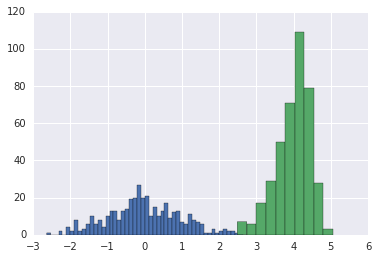

In [3]:
#Scale and standardize metabolites
X = discovery_mets[discovery_mets.columns[0:659]]
y = (discovery_mets['shannon'])
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
Xcolumns=X.columns
X = scaler.fit_transform(X)
X=pd.DataFrame(data=X,columns=Xcolumns)
print (X.shape)
sns.set(font_scale=1.00)
#test scaling
print (X['root.metabolite.scaled.lipid.steroid.5alpha-androstan-3beta,17alpha-diol disulfate:scaled'].hist(bins=50))
#plot histogram of outcome variable shannon
plt.hist(y)

In [4]:
## run cross_val_score on ridge and lasso to get out-of-sample R2 scores across 10-CV
#defining L2 parameters to be tested
alphas = np.linspace(1,1000,200)
#Defining LASSO and Ridge parameters
lassocv=LassoCV(eps=0.175, n_alphas=200, alphas=None, fit_intercept=True, normalize=False, precompute='auto', cv=10)
ridgecv=RidgeCV(alphas=alphas,fit_intercept=True,normalize=False,cv=10)
#Running 10-fold CV score function to get mean out-of-sample R2
discovery_score=cross_val_score(lassocv,X,y,cv=10)
print ('mean out-of-sample R2 LASSO',np.mean(discovery_score))
discovery_score_ridge=cross_val_score(ridgecv,X,y,cv=10)
print ('mean out-of-sample R2 Ridge',np.mean(discovery_score_ridge))

mean out-of-sample R2 LASSO 0.44773547745248166
mean out-of-sample R2 Ridge 0.35029958259542143


In [5]:
#Run Cross-validation and extract Beta_coefficients for each model
#Save predictions from each test set
lassocv=LassoCV(eps=0.175, n_alphas=200, alphas=None, fit_intercept=True, normalize=False, precompute='auto', cv=10)
y=discovery_mets['shannon']
y=y.reset_index()
y.drop(['public_client_id'],1,inplace=True)
X_folds = np.array_split(X, 10)
y_folds = np.array_split(y, 10)
coefficients=pd.DataFrame(index=X.columns).astype('float64')
predictions=[]
alphas= []
score= []
for k in range(10):
    X_train = list(X_folds)
    X_test  = X_train.pop(k)
    X_train = np.concatenate(X_train)
    y_train = list(y_folds)
    y_test  = y_train.pop(k)
    y_test=[ x[0] for x in  list(y_test.values)]
    y_train = np.concatenate(y_train)
    lassocv.fit(X_train, y_train)
    predictions.append(lassocv.predict(X_test).flatten())
    coef=list(lassocv.coef_)
    coefficients[k]=coef
    alphas.append(lassocv.alpha_)
    score.append(r2_score(y_test,lassocv.predict(X_test)))
#The L1 penalty for each model
print (alphas)
predictions_lasso=[item for sublist in predictions for item in sublist]
#Checking r2 score and pearson r
print ('mean R2 Score LASSO',np.mean(score))
print ('std. deviation for R2 Score',np.std(score))
print ('S.E.M',np.std(score)/np.sqrt(10))
print ('observed v predicted pearson r',stats.pearsonr(discovery_mets['shannon'],predictions_lasso))

[0.039961541031946914, 0.04012354796331661, 0.038168395402216365, 0.041451457326540785, 0.03903085906919329, 0.03956689974099288, 0.0449161949755424, 0.03867589675958929, 0.03995461545690002, 0.041599615043147055]
mean R2 Score LASSO 0.44773547745248166
std. deviation for R2 Score 0.10613472897414768
S.E.M 0.03356274824029728
observed v predicted pearson r (0.6834440092504868, 3.2077766743029246e-56)


In [6]:
score

[0.39665089503028816,
 0.4656497277602285,
 0.29451524141525365,
 0.49544548033571023,
 0.5399612577755215,
 0.510428129932263,
 0.21306445986320244,
 0.5331059114725891,
 0.5017136888363531,
 0.5268199821034075]

In [7]:
predictions=pd.DataFrame(index=discovery_mets.index)
predictions['predictions']=predictions_lasso
predictions['shannon']=discovery_mets['shannon']
predictions.to_csv("predictions.csv")

# Plotting predicted versus observed Fig. 1A

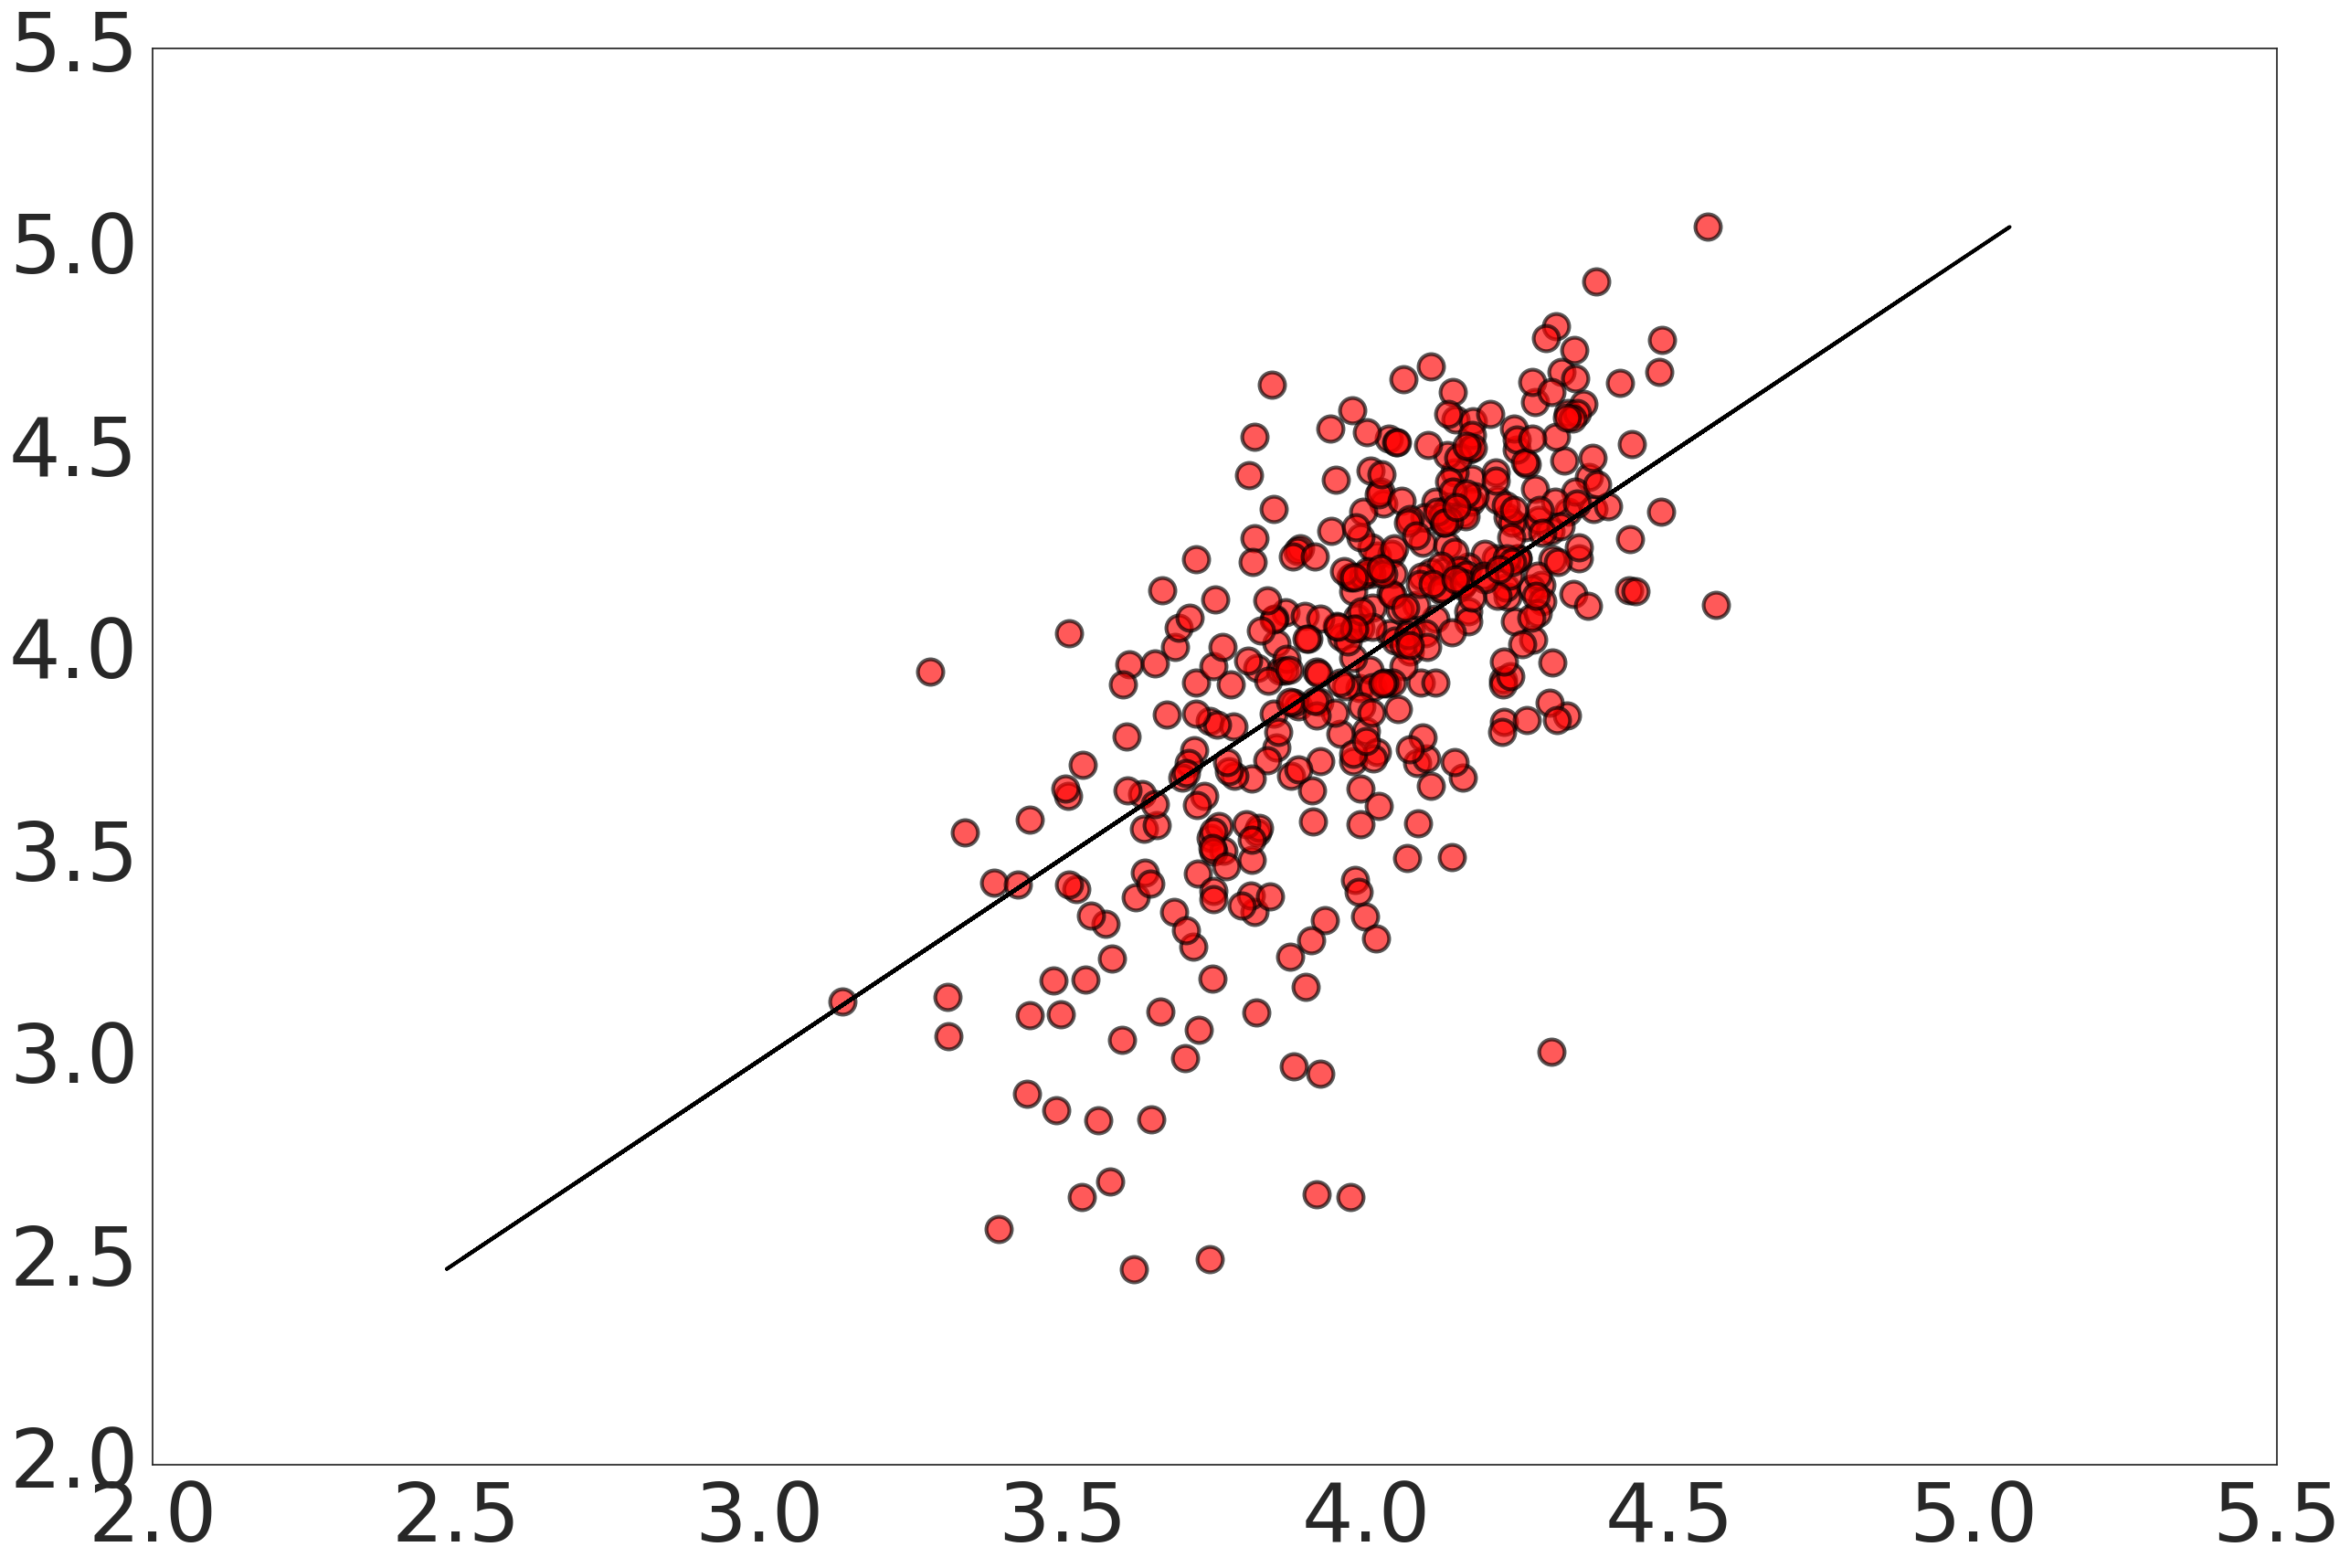

In [8]:
sns.set(font_scale=4.00,context='poster',font='Arial',style='white')
plt.figure(figsize=[30,20], dpi=100)
plt.scatter(predictions_lasso, discovery_mets['shannon'],s=400,color='r',alpha=0.65,linewidth=3,edgecolors='black')
plt.plot(y,y,color='black')

In [9]:
#Identifying all metabolites with non-zero Beta Coefficients for figures 1B&C
for x in coefficients.index.tolist():
    if (coefficients.loc[x] == 0.0).sum()==10:
        coefficients.drop([x],inplace=True)
print (coefficients.shape)
#calculating mean beta-coefficient for each metabolite and counting no. of times each metabolite had a 0 beta-coefficient.
means=[]
std=[]
zeroes=[]
for x in coefficients.index.tolist():
    means.append((np.mean(coefficients.loc[x])))
    std.append((np.std(coefficients.loc[x])))
    zeroes.append((coefficients.loc[x] == 0.0).astype(int).sum())
coefficients['mean']=means
coefficients['std_dev']=std
coefficients['zeroes']=zeroes
#save table as csv
coefficients[coefficients['zeroes']==0].to_csv('_40_coefs.csv')
coefficients.sort_values(by='mean',ascending=False).head()

(40, 10)


,0,1,2,3,4,5,6,7,8,9,mean,std_dev,zeroes
"root.metabolite.scaled.lipid.steroid.5alpha-androstan-3beta,17alpha-diol disulfate:scaled",0.066463,0.071688,0.075548,0.079401,0.086062,0.074617,0.079345,0.086107,0.080450,0.085282,0.078496,0.006176,0
root.metabolite.scaled.xenobiotics.benzoate_metabolism.hippurate:scaled,0.075347,0.058071,0.061615,0.059721,0.062048,0.061329,0.058928,0.060168,0.040132,0.037057,0.057441,0.010511,0
root.metabolite.scaled.xenobiotics.food_component_plant.cinnamoylglycine:scaled,0.047287,0.056804,0.021443,0.060724,0.050004,0.052995,0.086802,0.047123,0.069107,0.073827,0.056612,0.016886,0
root.metabolite.scaled.amino_acid.phenylalanine_and_tyrosine_metabolism.p-cresol sulfate:scaled,0.058071,0.066334,0.062401,0.050803,0.049018,0.056246,0.022637,0.050644,0.049763,0.050510,0.051643,0.011175,0
root.metabolite.scaled.xenobiotics.food_component_plant.methyl glucopyranoside (alpha + beta):scaled,0.020713,0.028351,0.036733,0.032002,0.023007,0.021079,0.025953,0.031032,0.034010,0.025521,0.027840,0.005232,0


# Assessing collinearity, supplementary Figure 1

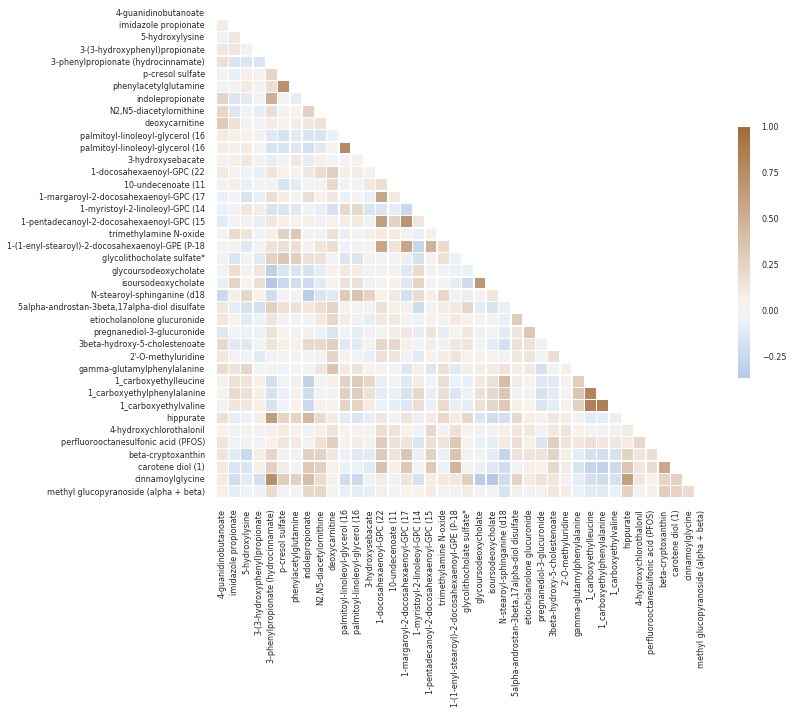

In [10]:
#Select only the 40 identified mets for correlation
corr_df=pd.DataFrame(index=discovery_mets.index)
for x in coefficients.index.tolist():
    corr_df[x]=discovery_mets[x]
#Change metabolite names to just the name (no family, subfamily)
corr_df.columns=list([x.split(":")[0].split(".")[-1] for x in corr_df.columns.tolist()])
# Compute the correlation matrix
corr = corr_df.corr('pearson')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
sns.set(font_scale=0.50,context='poster',font='Arial',style='white')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(250, 40, as_cmap=True)
heatmap=sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
heatmap
#plt.savefig('heatmap_40_.png',dpi=200)

In [11]:
#no. of corellations >0.80
r=corr.values.flatten()
#remove corelations of metabolites with themselves (r=1)
print (len(r))
r = [x for x in r if x !=1]
print (len(r))
#count number of correlations where absolute value of r>0.80
print (len([i for i in r if abs(i)>0.80]))

1600
1560
6


In [12]:
sns.set(font_scale=1.00,context='poster',font='Arial',style='white')
corr_df=pd.DataFrame()
for x in coefficients.index.tolist():
    corr_df[x]=X[x]
corr_df
corr_df=corr_df.corr(method='pearson', min_periods=1)
#corr_df.replace(to_replace=1, value=0, inplace=True, limit=None, regex=False, method='pad')
r=corr_df.values.flatten()
r = [x for x in r if x !=1]
j=[]
j = [i for i in r if i>0.80]
print (len(j))
print (len(r))

6
1560


(array([  6.,   6.,   8.,  32.,  48.,  84., 104., 134., 192., 170., 190.,
        152., 114.,  92.,  64.,  56.,  38.,  22.,   6.,   4.,   4.,   4.,
          2.,   6.,   6.,   2.,   4.,   2.,   4.,   4.]),
 array([-0.36365752, -0.32308337, -0.28250921, -0.24193506, -0.20136091,
        -0.16078676, -0.12021261, -0.07963846, -0.0390643 ,  0.00150985,
         0.042084  ,  0.08265815,  0.1232323 ,  0.16380645,  0.2043806 ,
         0.24495476,  0.28552891,  0.32610306,  0.36667721,  0.40725136,
         0.44782551,  0.48839966,  0.52897382,  0.56954797,  0.61012212,
         0.65069627,  0.69127042,  0.73184457,  0.77241872,  0.81299288,
         0.85356703]),
 <a list of 30 Patch objects>)

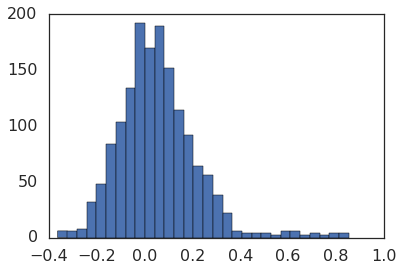

In [13]:
plt.hist(r,bins=30)

# PD whole tree and Chao1 predictions

In [14]:
#Using all metabolites to predict PD whole tree and Chao1
lassocv=LassoCV(eps=0.175, n_alphas=200, alphas=None, fit_intercept=True, normalize=False, precompute='auto', cv=10)
discovery_PD_all=cross_val_score(lassocv,X,discovery_mets['PD_whole_tree'],cv=10)
print ('PD whole tree all 659 mets mean out-of-sample R2',np.mean(discovery_PD_all))
discovery_Chao_all=cross_val_score(lassocv,X,discovery_mets['chao1'],cv=10)
print ('Chao1 all 659 mets mean out-of-sample R2',np.mean(discovery_Chao_all))

PD whole tree all 659 mets mean out-of-sample R2 0.46595868693020304
Chao1 all 659 mets mean out-of-sample R2 0.3325510389113281


In [15]:
#Testing prediction of other diversity metrics using just the 40 mets identified.
W=pd.DataFrame()
for x in discovery_mets.columns.tolist():
    if x in coefficients.index.tolist():
        W[x]=X[x]
print (W.shape)
lassocv=LassoCV(eps=0.01, n_alphas=200, alphas=None, fit_intercept=True, normalize=False, precompute='auto', cv=10)
discovery_PD40_=cross_val_score(lassocv,W,discovery_mets['PD_whole_tree'],cv=10)
print ('PD whole tree all 659 mets mean out-of-sample R2',np.mean(discovery_PD40_))
discovery_Chao40_=cross_val_score(lassocv,W,discovery_mets['chao1'],cv=10)
print ('Chao1 all 659 mets mean out-of-sample R2',np.mean(discovery_Chao40_))

(399, 40)
PD whole tree all 659 mets mean out-of-sample R2 0.4992750699044488
Chao1 all 659 mets mean out-of-sample R2 0.36160743908467713


In [16]:
pred_df=pd.DataFrame(index=discovery_mets.index)
whole_tree_pred=cross_val_predict(lassocv,W,discovery_mets['PD_whole_tree'],cv=10)
pred_df['pd_preds']=whole_tree_pred
print (stats.pearsonr(whole_tree_pred,discovery_mets['PD_whole_tree']))
chao_pred=cross_val_predict(lassocv,W,discovery_mets['chao1'],cv=10)
pred_df['chao_preds']=chao_pred
print (stats.pearsonr(whole_tree_pred,discovery_mets['chao1']))

(0.7140027754897283, 1.9348124199774476e-63)
(0.6158476146162507, 5.040407821969645e-43)


In [17]:
pred_df.to_csv('pred_df.csv')

# Validation Cohort Analysis

shape of metabolite df (540, 659)
Axes(0.125,0.125;0.775x0.775)


(array([  8.,  13.,  15.,  48.,  69.,  88., 129., 107.,  52.,  11.]),
 array([3.27846136, 3.45834641, 3.63823147, 3.81811652, 3.99800157,
        4.17788662, 4.35777168, 4.53765673, 4.71754178, 4.89742684,
        5.07731189]),
 <a list of 10 Patch objects>)

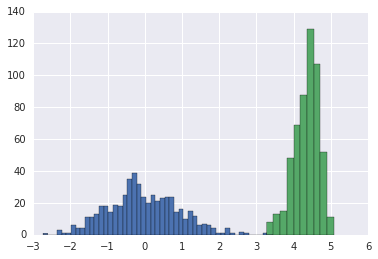

In [18]:
#Metabolomics Validation
#Scaling and standardizing the validation cohort
y_validation = (second_genome['shannon'])
vendor = second_genome[second_genome.columns[0:659]]
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
Xcolumns=vendor.columns
Xindex=vendor.index
vendor = scaler.fit_transform(vendor)
vendor=pd.DataFrame(data=vendor,columns=Xcolumns)
print ('shape of metabolite df',vendor.shape)
sns.set(font_scale=1.00)
#test scaling
print (vendor['root.metabolite.scaled.amino_acid.alanine_and_aspartate_metabolism.N-acetylalanine:scaled'].hist(bins=50))
#histogram of outcome variable shannon
plt.hist(y_validation)

In [19]:
#Run LASSO using all 659 Mets
## run cross_val_score on ridge and lasso to get out-of-sample R2 scores across 10-CV
lassocv=LassoCV(eps=0.175, n_alphas=200, alphas=None, fit_intercept=True, normalize=False, precompute='auto', cv=10)
validation_score=cross_val_score(lassocv,vendor,y_validation,cv=10)
print ('mean out-of-sample R2 LASSO',np.mean(validation_score))

mean out-of-sample R2 LASSO 0.37799936077446383


In [20]:
#Predict shannon using just the 40 metabolites identified in the discovery cohort
for x in vendor.columns.tolist():
    if x not in coefficients.index.tolist():
        vendor.drop([x],1,inplace=True)
print (vendor.shape)
lassocv=LassoCV(eps=0.05, n_alphas=200, alphas=None, fit_intercept=True, normalize=False, precompute='auto', cv=10)
validation40_score=cross_val_score(lassocv,vendor,y_validation,cv=10)
print ('mean out-of-sample R2 LASSO 40 mets validation',np.mean(validation40_score))
print ('std deviation of R2 score',np.std(validation40_score))

(540, 40)
mean out-of-sample R2 LASSO 40 mets validation 0.3425722058905879
std deviation of R2 score 0.07784909649313117


In [21]:
#Assessing whether performance is significantly different across the 10-CVs between whole metabolome model and the 40 metabolite model
print ('ttest 40 mets vs. 659 mets',stats.ttest_ind(validation_score,validation40_score))

ttest 40 mets vs. 659 mets Ttest_indResult(statistic=1.0558927573271486, pvalue=0.30498393598737583)


In [22]:
#Extracting Beta coefficients from 10-fold cv using only 40 mets in the validation set
lassocv=LassoCV(eps=0.05, n_alphas=200, alphas=None, fit_intercept=True, normalize=False, precompute='auto', cv=10)
y=y_validation
y=y.reset_index()
y.drop(['public_client_id'],1,inplace=True)
from sklearn.model_selection import KFold
X_folds = np.array_split(vendor, 10)
y_folds = np.array_split(y, 10)
coefficients_validation=pd.DataFrame(index=vendor.columns).astype('float64')
predictions_validation=[]
alphas= []
score_validation= []
for k in range(10):
    X_train = list(X_folds)
    X_test  = X_train.pop(k)
    X_train = np.concatenate(X_train)
    y_train = list(y_folds)
    y_test  = y_train.pop(k)
    y_test=[ x[0] for x in  list(y_test.values)]
    y_train = np.concatenate(y_train)
    lassocv.fit(X_train, y_train)
    predictions_validation.append(lassocv.predict(X_test).flatten())
    coef=list(lassocv.coef_)
    coefficients_validation[k]=coef
    alphas.append(lassocv.alpha_)
    score_validation.append(r2_score(y_test,lassocv.predict(X_test)))
print (lassocv.alpha_)
print (alphas)
predictions_validation=[item for sublist in predictions_validation for item in sublist]
#Identifying all metabolites with non-zero Beta Coefficients
means=[]
std=[]
zeroes=[]
for x in coefficients_validation.index.tolist():
    means.append((np.mean(coefficients_validation.loc[x])))
    std.append((np.std(coefficients_validation.loc[x])))
    zeroes.append((coefficients_validation.loc[x] == 0).astype(int).sum())
coefficients_validation['mean']=means
coefficients_validation['std_dev']=std
coefficients_validation['zeroes']=zeroes
coefficients_validation.sort_values(by='mean')
coefficients_validation.to_csv('coeff_validation.csv')

0.006481230778656312
[0.008129124361579266, 0.006676462334191416, 0.006490687317870491, 0.0067549541501457765, 0.006788824190485651, 0.006717885227298037, 0.006905487094547851, 0.006776899721933358, 0.006981219855903212, 0.006481230778656312]


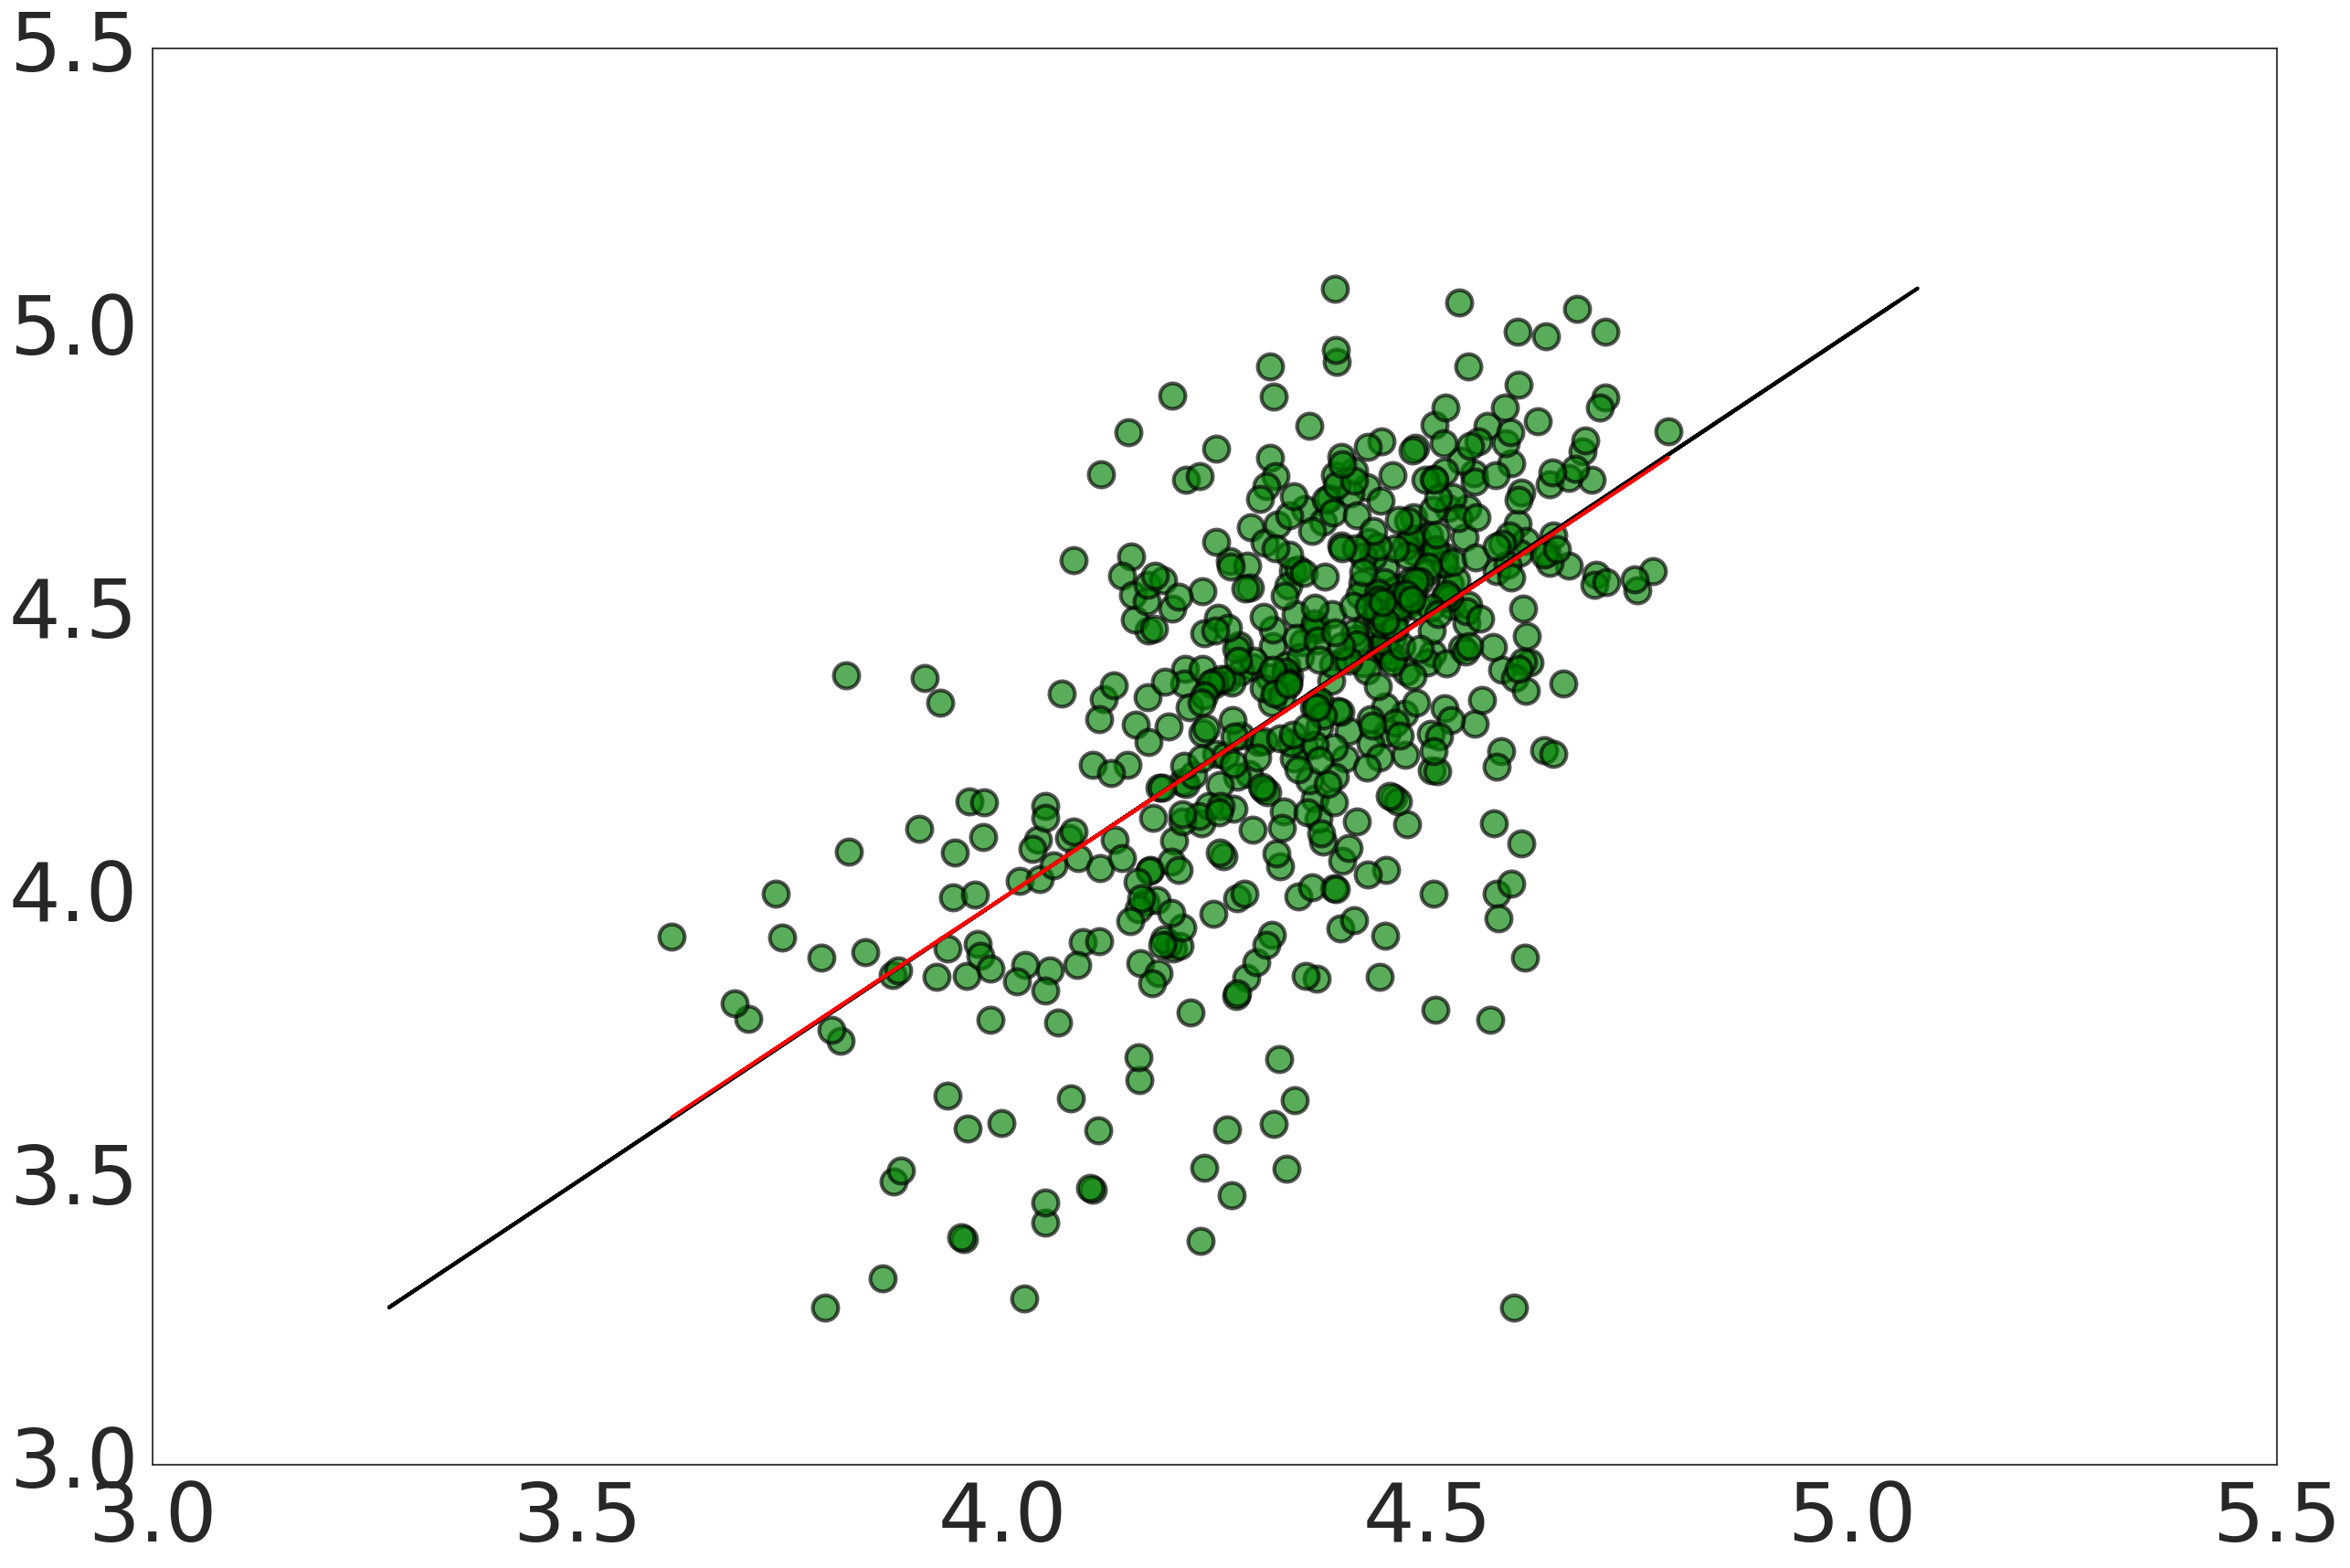

In [23]:
#Plotting predicted versus observed Shannon values in the validation cohort, Fig. 6A
sns.set(font_scale=4.00,context='poster',font='Arial',style='white')
plt.figure(figsize=[30,20], dpi=100)
plt.scatter(predictions_validation, second_genome['shannon'],s=400,color='g',alpha=0.65,linewidth=3,edgecolors='black')
plt.plot(y,y,color='black')
plt.plot(predictions_validation, np.poly1d(np.polyfit(predictions_validation,second_genome['shannon'], 1))(predictions_validation),color='r',linewidth=2.5)

spearman rho= SpearmanrResult(correlation=0.9, pvalue=0.00015997142806871369)
Pearson R= (0.9374199588043086, 2.0511612367360166e-05)


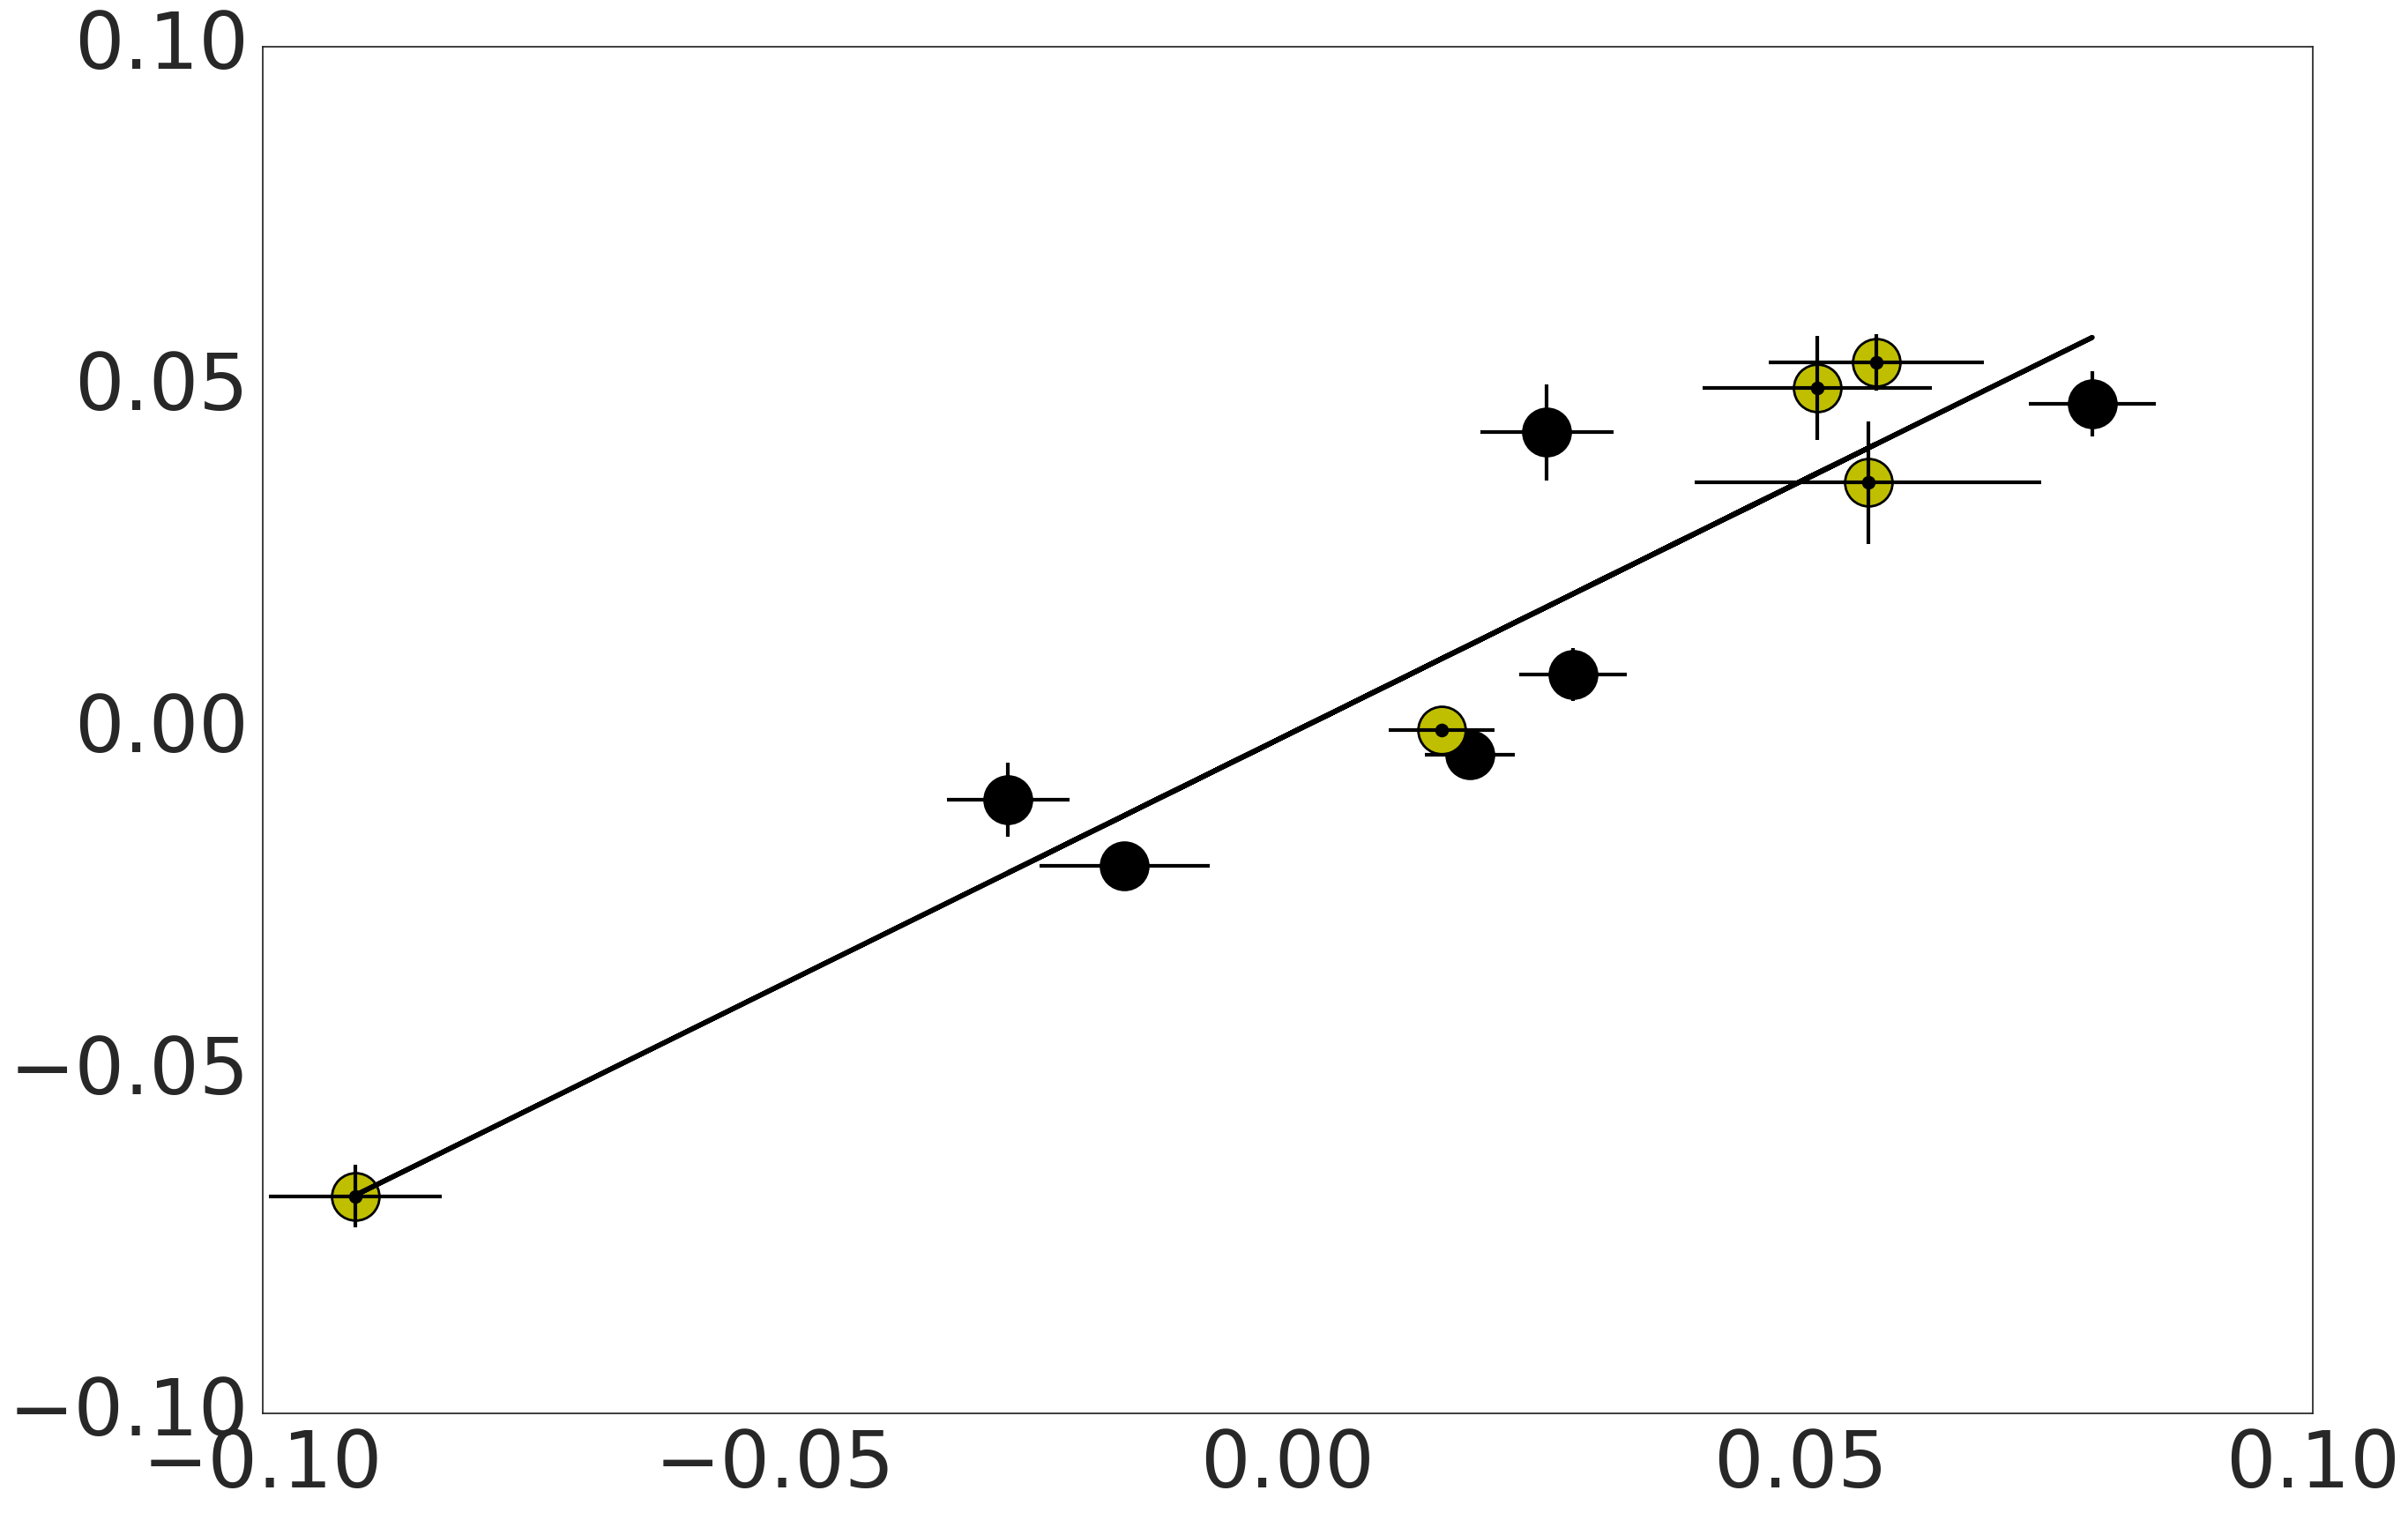

In [24]:
#comparing beta coefficients across discovery and validation sets (Figure 6B)
top_11_=coefficients[coefficients['zeroes']==0].index.tolist()
correlating_coef=pd.DataFrame(index=top_11_)
correlating_coef['mean_discovery']=coefficients['mean']
correlating_coef['mean_validation']=coefficients_validation['mean']
correlating_coef['std_validation']=coefficients_validation['std_dev']
correlating_coef['std_discovery']=coefficients['std_dev']
#identifying microbial cometabolites for hue
comets=['root.metabolite.scaled.lipid.secondary_bile_acid_metabolism.isoursodeoxycholate:scaled','root.metabolite.scaled.xenobiotics.benzoate_metabolism.hippurate:scaled',
       'root.metabolite.scaled.xenobiotics.food_component_plant.cinnamoylglycine:scaled','root.metabolite.scaled.amino_acid.phenylalanine_and_tyrosine_metabolism.p-cresol sulfate:scaled',
       'root.metabolite.scaled.lipid.secondary_bile_acid_metabolism.glycolithocholate sulfate*:scaled']
hue=[]
for x in correlating_coef.index.tolist():
    if x in comets:
        hue.append(1)
    else:
        hue.append(0)
correlating_coef['hue']=hue
sns.set(font_scale=4.00,context='poster',font='Arial',style='white')
plt.figure(figsize=[30,20], dpi=100)
plt.figure(figsize=[30,20], dpi=100)
disc=correlating_coef['std_discovery'].tolist()
val=correlating_coef['std_validation'].tolist()
not_comets=correlating_coef[correlating_coef['hue']==0]
comets=correlating_coef[correlating_coef['hue']==1]
#plotting figure
plt.errorbar(correlating_coef['mean_discovery'],correlating_coef['mean_validation'], xerr=disc, yerr=val,fmt='o',color='k',linewidth=3)
plt.scatter(not_comets['mean_discovery'], not_comets['mean_validation'],s=1500,color='k',linewidth=2,alpha=1,edgecolors='black')
plt.scatter(comets['mean_discovery'], comets['mean_validation'],s=1500,color='y',linewidth=2,alpha=1,edgecolors='k')
plt.plot(correlating_coef['mean_discovery'], np.poly1d(np.polyfit(correlating_coef['mean_discovery'],correlating_coef['mean_validation'], 1))(correlating_coef['mean_discovery']),color='k',linewidth=4)
plt.xlim(-.10,.10)
plt.ylim(-.10,.10)
#running pearson and spearman on the mean model beta-coefficients across cohorts
spearman=stats.spearmanr(correlating_coef['mean_discovery'],correlating_coef['mean_validation'])
print ('spearman rho=',spearman)
pearson=stats.pearsonr(correlating_coef['mean_discovery'],correlating_coef['mean_validation'])
print ('Pearson R=',pearson)

In [25]:
coefficients[coefficients['zeroes']==0].to_csv('_11_mets.csv')

Performing additional analysis on antibiotics. Does excluding antibiotics users improve model performance

In [26]:
#import GI health and antibiotics response df
GI_health=pd.DataFrame.from_csv("GI_health.csv")
GI_health.index=GI_health.index.astype('float64')
#exlcude participants who reported antibiotics use in the last three months
GI_health=GI_health[GI_health['antibiotics_enum']<2]
GI_health.shape

(283, 14)

(283, 659)
Axes(0.125,0.125;0.775x0.775)


(array([ 4.,  4.,  7., 26., 37., 43., 79., 62., 19.,  2.]),
 array([2.50988594, 2.76489479, 3.01990364, 3.27491248, 3.52992133,
        3.78493018, 4.03993903, 4.29494787, 4.54995672, 4.80496557,
        5.05997442]),
 <a list of 10 Patch objects>)

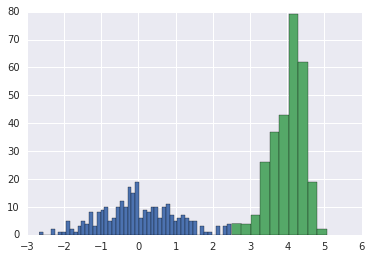

In [27]:
#Scale and standardize metabolites for non-antibiotics analysis
mets_antib=discovery_mets[discovery_mets.index.isin(GI_health.index.tolist())]
X = mets_antib[mets_antib.columns[0:659]]
y = (mets_antib['shannon'])
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
Xcolumns=X.columns
X = scaler.fit_transform(X)
X=pd.DataFrame(data=X,columns=Xcolumns)
print (X.shape)
sns.set(font_scale=1.00)
#test scaling
print (X['root.metabolite.scaled.lipid.steroid.5alpha-androstan-3beta,17alpha-diol disulfate:scaled'].hist(bins=50))
#plot histogram of outcome variable shannon
plt.hist(y)

In [28]:
#Running LASSO with just 40 mets on non-antibiotics users
lassocv=LassoCV(eps=0.05, n_alphas=200, alphas=None, fit_intercept=True, normalize=False, precompute='auto', cv=10)
sub_df=pd.DataFrame(data=X)
for x in sub_df.columns.tolist():
    if x not in coefficients.index.tolist():
        sub_df.drop([x],1,inplace=True)
print (sub_df.shape)
antib40_score=cross_val_score(lassocv,sub_df,y,cv=10)
print ('mean out-of-sample R2 LASSO 40 mets validation',np.mean(antib40_score))
print ('std.dev out-of-sample R2 LASSO 40 mets validation',np.std(antib40_score))

(283, 40)
mean out-of-sample R2 LASSO 40 mets validation 0.48359661626565253
std.dev out-of-sample R2 LASSO 40 mets validation 0.1424685289146398


In [29]:
#Running 10-fold CV score function to get mean out-of-sample R2 using the whole metabolome
antib_score=cross_val_score(lassocv,X,y,cv=10)
print ('mean out-of-sample R2 LASSO',np.mean(antib_score))
print ('std. dev. out-of-sample R2 LASSO',np.std(antib_score))

mean out-of-sample R2 LASSO 0.4587732646028412
std. dev. out-of-sample R2 LASSO 0.10903159867093806


In [30]:
#getting out of sample predictions for the 40 metabolite model in non-antib users
preds_antib=cross_val_predict(lassocv,sub_df,y,cv=10)
print ('pearson correlation predicted versus observed',stats.pearsonr(preds_antib,y))

pearson correlation predicted versus observed (0.7118643262231833, 5.002043707974934e-45)


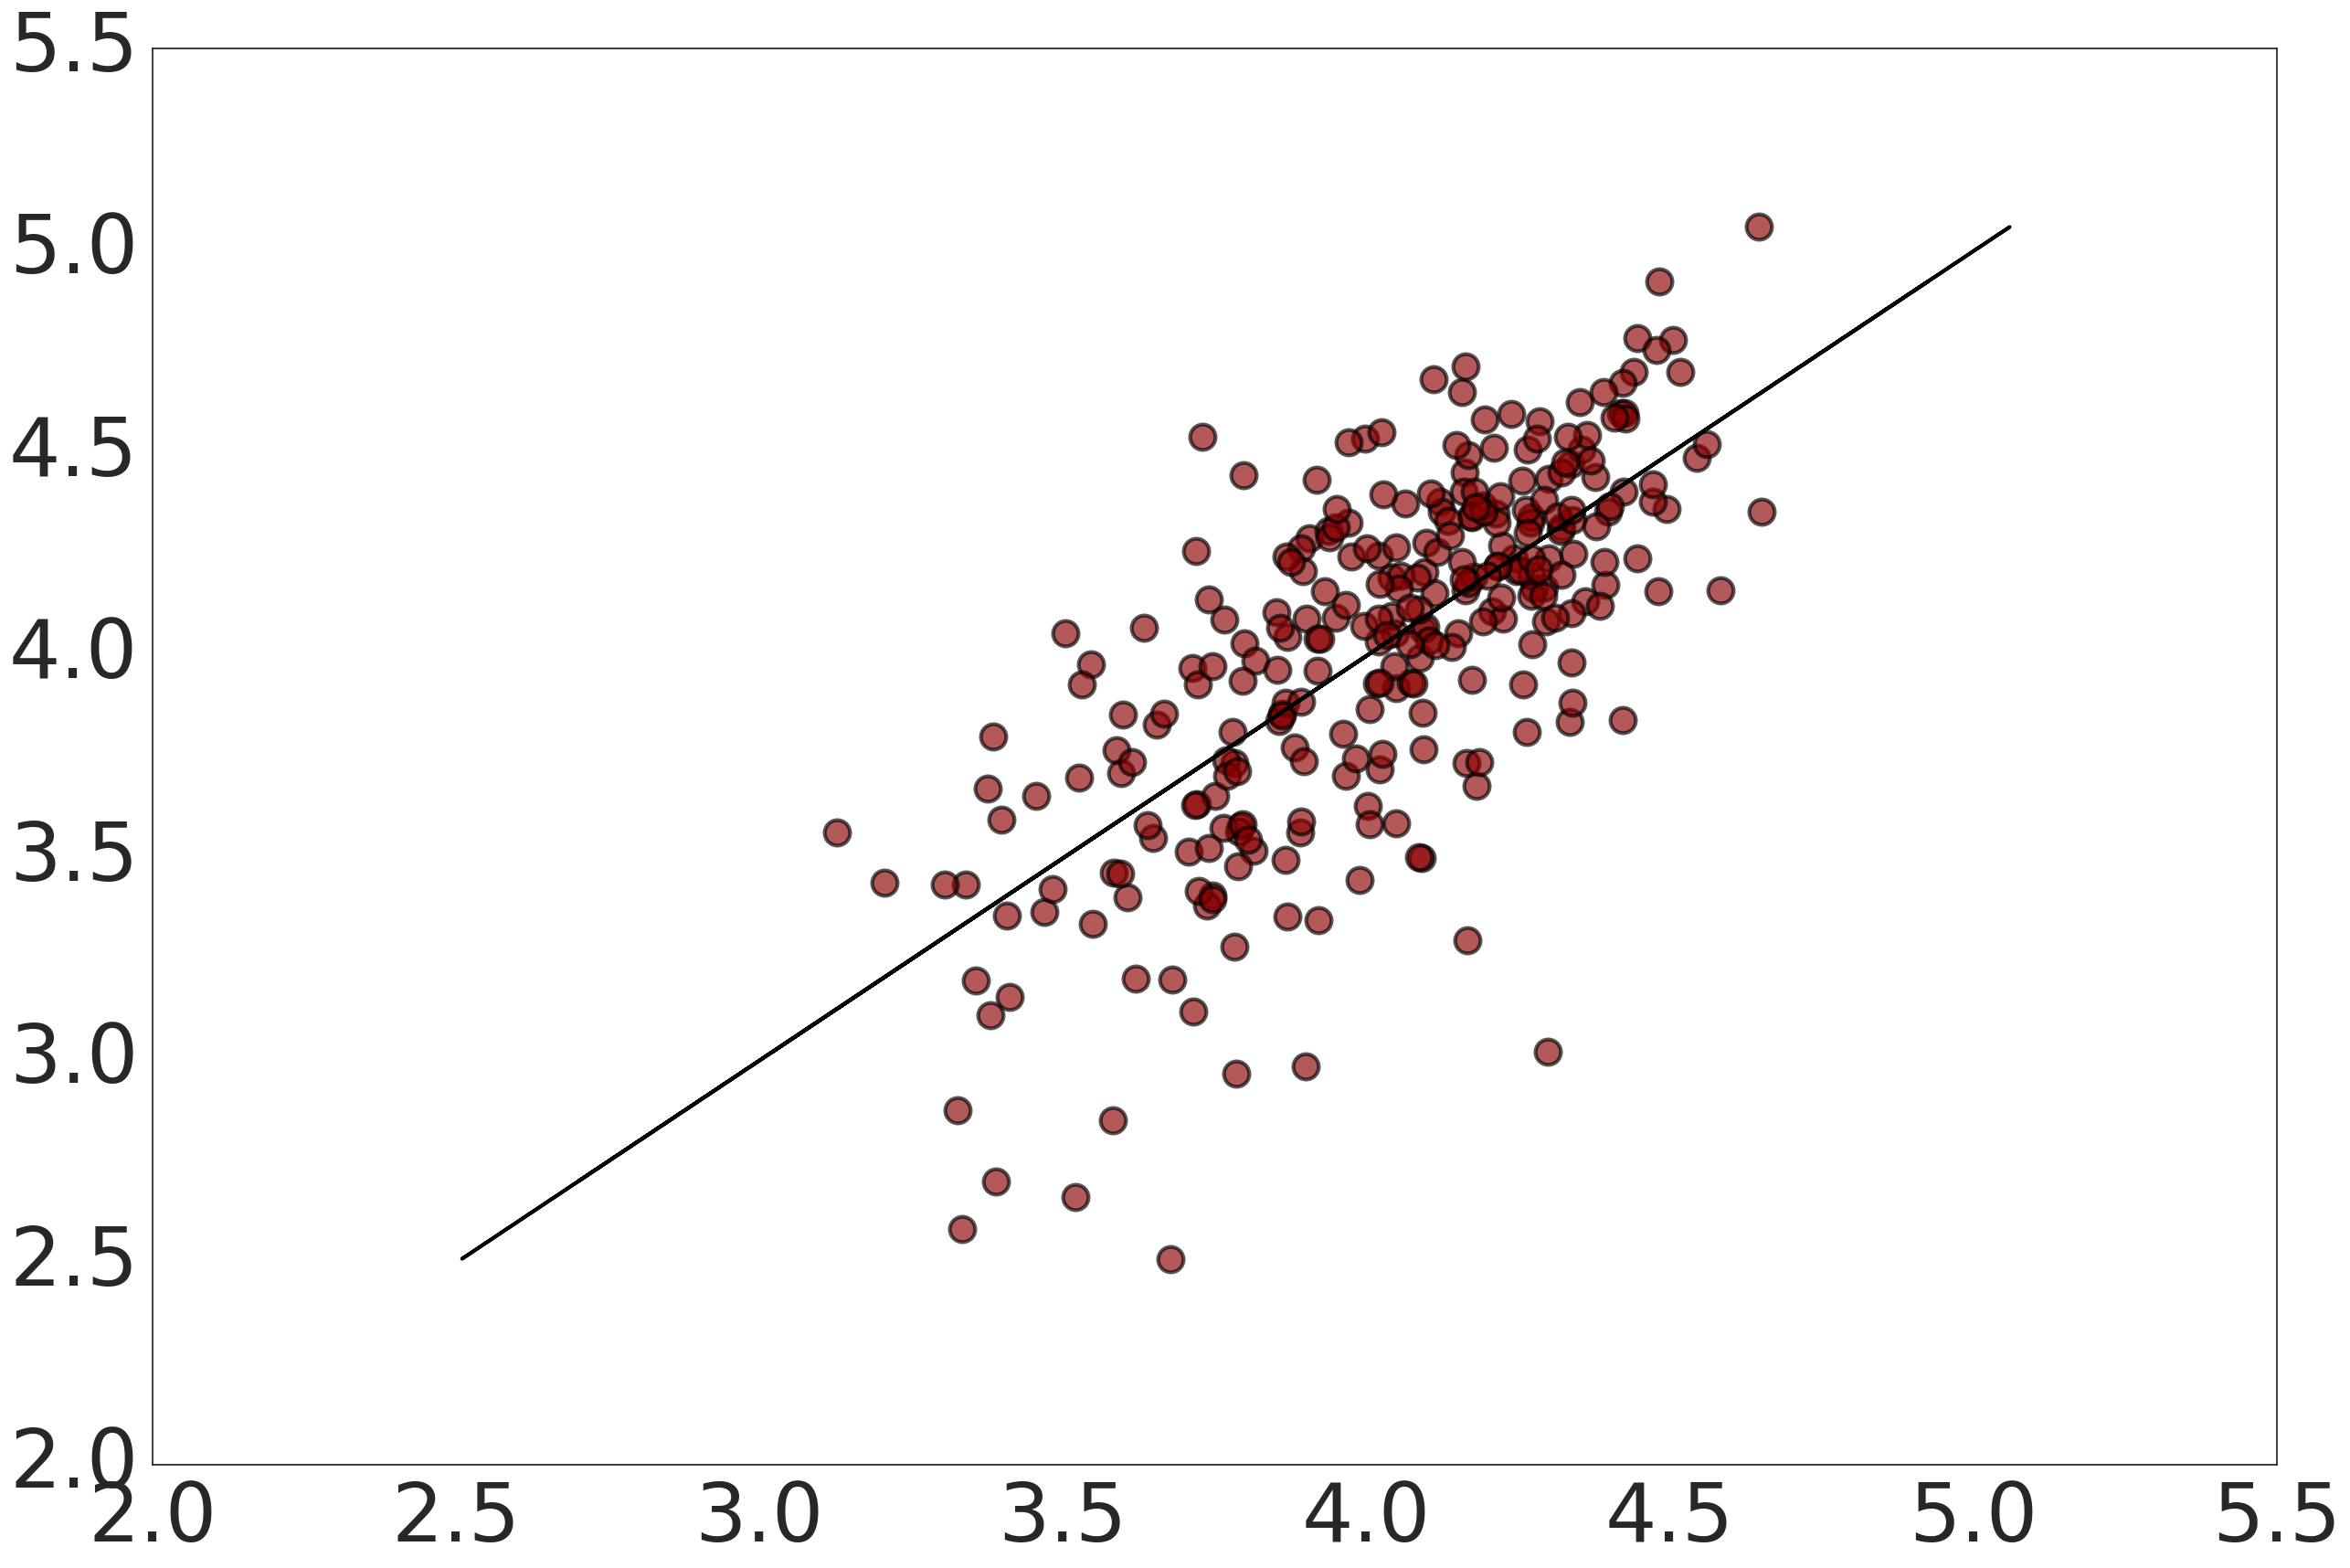

In [31]:
#Plotting predicted versus observed Shannon values in the validation cohort, Fig. 6A
sns.set(font_scale=4.00,context='poster',font='Arial',style='white')
plt.figure(figsize=[30,20], dpi=100)
plt.scatter(preds_antib, y,s=400,color='darkred',alpha=0.65,linewidth=3,edgecolors='black')
plt.plot(y,y,color='black')

In [32]:
print ('ttest whole cohort vs. non-antib users (40 mets)',stats.ttest_ind(score,antib40_score))

ttest whole cohort vs. non-antib users (40 mets) Ttest_indResult(statistic=-0.6055695376824718, pvalue=0.552360435610999)
